In [74]:
#Doc https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/introduction_to_SH_APIs.html
#API KEY : https://shapps.dataspace.copernicus.eu/dashboard/#/

In [75]:
#!pip install sentinelhub

In [76]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

#from utils import plot_image

In [77]:
client_id= 'sh-4eaa164d-79a2-48ec-86c8-d0a376a229ee'
client_secret= '4HAs1tuR40KXNHvovCrKoacuab3iTYrm'

In [78]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = client_id
config.sh_client_secret = client_secret
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

In [79]:

# Definir el área de interés (AOI) con 4 puntos de lat/lon
lon_min = -63.95
lat_min = -31.75
lon_max = -63.75
lat_max = -31.60

aoi_coords_wgs84 = [lon_min, lat_min, lon_max, lat_max]

In [80]:
resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 10 m resolution: (1883, 1677) pixels


In [81]:
catalog = SentinelHubCatalog(config=config)
catalog

In [82]:
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
time_interval = "2025-07-01", "2025-07-20"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Total number of results: 10


[{'id': 'S2A_MSIL2A_20250719T141111_N0511_R110_T20HMK_20250719T211521.SAFE',
  'properties': {'datetime': '2025-07-19T14:21:58.521Z'}},
 {'id': 'S2A_MSIL2A_20250719T141111_N0511_R110_T20JML_20250719T211521.SAFE',
  'properties': {'datetime': '2025-07-19T14:21:44.092Z'}},
 {'id': 'S2C_MSIL2A_20250717T141111_N0511_R110_T20HMK_20250717T173322.SAFE',
  'properties': {'datetime': '2025-07-17T14:22:02.422Z'}},
 {'id': 'S2C_MSIL2A_20250717T141111_N0511_R110_T20JML_20250717T173322.SAFE',
  'properties': {'datetime': '2025-07-17T14:21:47.995Z'}},
 {'id': 'S2B_MSIL2A_20250712T140709_N0511_R110_T20HMK_20250712T173831.SAFE',
  'properties': {'datetime': '2025-07-12T14:21:42.721Z'}},
 {'id': 'S2B_MSIL2A_20250712T140709_N0511_R110_T20JML_20250712T173831.SAFE',
  'properties': {'datetime': '2025-07-12T14:21:28.273Z'}},
 {'id': 'S2C_MSIL2A_20250707T141111_N0511_R110_T20HMK_20250707T191716.SAFE',
  'properties': {'datetime': '2025-07-07T14:22:01.949Z'}},
 {'id': 'S2C_MSIL2A_20250707T141111_N0511_R110_T

In [83]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2025-07-01", "2025-07-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

In [84]:
true_color_imgs = request_true_color.get_data()

In [85]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}. and has shape {true_color_imgs[0].shape}"
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1. and has shape (1677, 1883, 3)
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1677, 1883, 3)


Image type: uint8


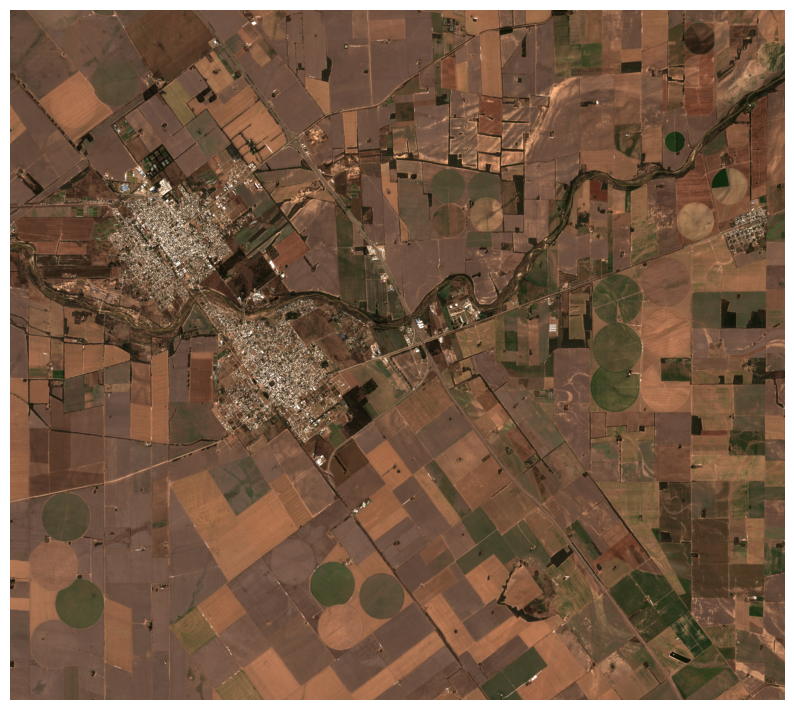

In [86]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image, factor=1.0, clip_range=(0, 1)):
    """
    Plot an image with optional scaling and clipping.
    
    :param image: The image array to plot
    :param factor: Scaling factor to apply to the image
    :param clip_range: Tuple of (min, max) values to clip the image to
    """
    # Apply scaling factor
    scaled_image = image * factor
    
    # Clip the image values
    clipped_image = np.clip(scaled_image, clip_range[0], clip_range[1])
    
    # Create a new figure
    plt.figure(figsize=(10, 10))
    
    # Display the image
    plt.imshow(clipped_image)
    
    # Remove axes
    plt.axis('off')
    
    # Show the plot
    plt.show()

# Now you can use the function
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [87]:
import numpy as np
import rasterio
from rasterio.transform import from_bounds
def process_and_save_georeferenced_image(image, output_path, bbox, factor=1.0, clip_range=(0, 1)):
    """
    Process an image with optional scaling and clipping, and save as a georeferenced TIFF.
    :param image: The image array to process
    :param output_path: Path to save the output TIFF file
    :param bbox: BBox object containing the bounding box of the image
    :param factor: Scaling factor to apply to the image
    :param clip_range: Tuple of (min, max) values to clip the image to
    """
    # Apply scaling factor
    scaled_image = image * factor
    
    # Clip the image values
    clipped_image = np.clip(scaled_image, clip_range[0], clip_range[1])
    
    # Ensure the image is in the correct format for saving
    # Convert to 8-bit unsigned integer
    image_8bit = (clipped_image * 255).astype(np.uint8)
    
    # Get image dimensions
    height, width, bands = image_8bit.shape
    
    # Create the transformation
    transform = from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, width, height)
    
    # Define the CRS (WGS84)
    crs = rasterio.crs.CRS.from_epsg(4326)
    
    # Save as georeferenced TIFF
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=bands,
        dtype=image_8bit.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        for i in range(bands):
            dst.write(image_8bit[:,:,i], i+1)
    
    print(f"Georeferenced image saved as {output_path}")
# Now you can use the function
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")
# Process and save the image
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
output_path = 'processed_georeferenced_image.tiff'
# Use aoi_bbox directly
bbox = aoi_bbox  # This is already a BBox object
process_and_save_georeferenced_image(image, output_path, bbox, factor=3.5 / 255, clip_range=(0, 1))

Image type: uint8
Georeferenced image saved as processed_georeferenced_image.tiff


In [88]:
#changes in images

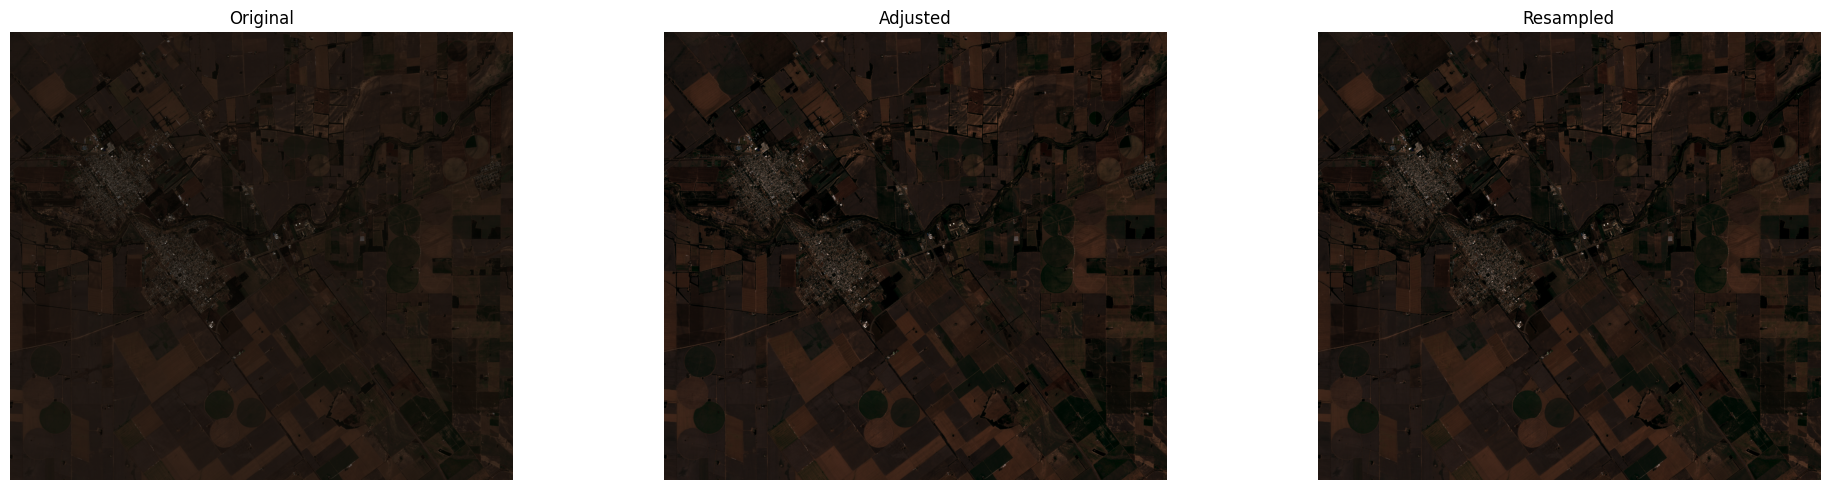

In [89]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming true_color_imgs is your list containing the image
image = true_color_imgs[0]  # Get the first (and only) image from the list

def adjust_image(img, factor=20):
    img_float = img.astype(float)
    means = np.mean(img_float, axis=(0, 1))
    stds = np.std(img_float, axis=(0, 1))
    adjusted = np.clip(img_float + (img_float - means) * (factor * stds / 255), 0, 255)
    return adjusted.astype(np.uint8)

def resample_image(img, scale_factor=2):
    new_height = int(img.shape[0] * scale_factor)
    new_width = int(img.shape[1] * scale_factor)
    resampled = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return resampled

def display_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for ax, img, title in zip(axs, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Apply adjustments
adjusted_image = adjust_image(image)
resampled_image = resample_image(adjusted_image)

# Display results
display_images([image, adjusted_image, resampled_image], 
               ['Original', 'Adjusted', 'Resampled'])

In [90]:
#Silo detection

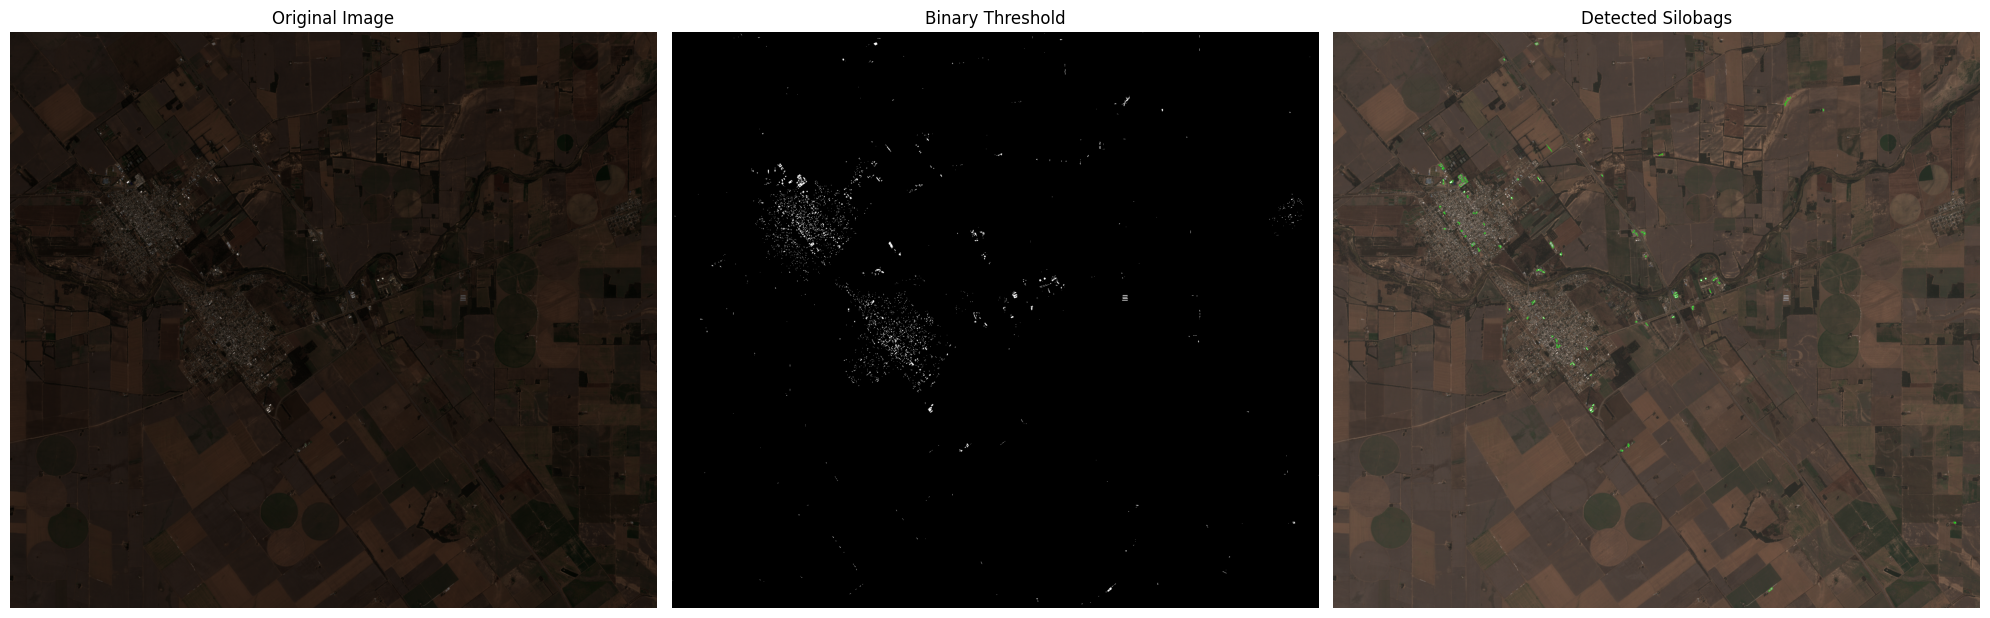

Number of detected silobags: 71


In [91]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhance_image(img, alpha=1.5, beta=30):
    # Increase contrast and brightness
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

def detect_silobags(image, threshold_value=200, min_area=10, max_area=100):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Enhance the image
    enhanced = enhance_image(gray)
    
    # Apply threshold to get binary image
    _, binary = cv2.threshold(enhanced, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area and aspect ratio
    filtered_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h
            if 0.5 < aspect_ratio < 3:  # Adjust this range as needed
                filtered_contours.append(cnt)
    
    return filtered_contours, binary

def draw_detections(image, contours):
    # Create a copy of the image to draw on
    result = image.copy()
    
    # Draw contours
    cv2.drawContours(result, contours, -1, (0, 255, 0), 1)
    
    return result

# Assuming 'image' is your input image
enhanced_image = enhance_image(image)
contours, binary = detect_silobags(enhanced_image, threshold_value=200, min_area=10, max_area=500)
result = draw_detections(enhanced_image, contours)

# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary Threshold')
ax2.axis('off')

ax3.imshow(result)
ax3.set_title('Detected Silobags')
ax3.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of detected silobags: {len(contours)}")